In [38]:
# 1 -> array[100]
# can we learn to reproduce a whole timeseries given a parameter?
# y is sin over 0.0-1.0 with (fixed frequency 10PI) and phase offset (x)

# works, and accuracy is functional. Why does it plateau?

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# might need to comment this out if you don't have a GPU
# perhaps unecessary in general, but I haven't found a way to make it work!
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

((2000,), (2000, 128))

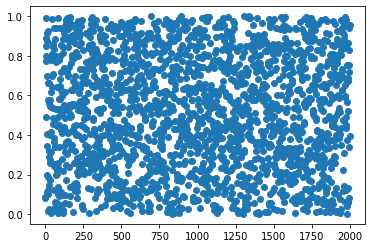

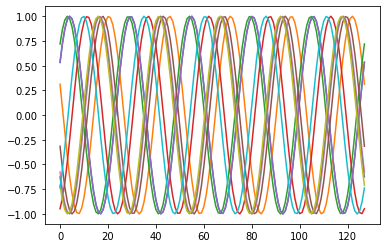

In [63]:
# x: given a random phase offset (I used fraction from 0.0 - 1.0)
# y: sine curve from 0.0 - 1.0 at freq 10*PI with given offset

N_POINTS = 128
N_EXAMPLES = 2000

def gen_example(phase_offset_frac, freq=1, amp=1):
    """phase_offset_frac in 0.0-1.0"""
    us = np.linspace(0, 1, N_POINTS)
    xs = us * (np.pi * 2) * freq + (2.0 * np.pi * phase_offset_frac)
    ys = np.sin(xs) * amp
    return np.array(ys)

phase_fracs = np.array([random.random() for _ in range(N_EXAMPLES)])
pairs = np.array([(phase_frac, gen_example(phase_frac, 5)) for phase_frac in phase_fracs])

plt.scatter(list(range(len(phase_fracs))), phase_fracs)
plt.figure()

for i in range(0, N_EXAMPLES, 200):
    xs, ys = pairs[i]
    plt.plot(ys)

xs = np.array([pair[0] for pair in pairs])
ys = np.array([pair[1] for pair in pairs])
xs.shape, ys.shape

In [64]:
# train / test split
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1340,), (1340, 128), (660,), (660, 128))

In [65]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               256       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
Total params: 16,768
Trainable params: 16,768
Non-trainable params: 0
_________________________________________________________________
0/0.4866/0.0031/0.4689/0.0125 20/0.0795/0.0838/0.0844/0.0900 40/0.0363/0.1050/0.0370/0.1225 60/0.0104/0.2206/0.0105/0.2000 80/0.0040/0.2887/0.0040/0.2800 100/0.0019/0.3575/0.0019/0.3575 120/0.0010/0.3900/0.0011/0.3700 140/0.0006/0.4419/0.0006/0.4875 160/0.0004/0.4794/0.0004/0.4800 180/0.0002/0.4900/0.0003/0.5150 200/0.0002/0.4981/0.0002/0.4800 220/0.0001/0.5263/0.0001/0.4850 2

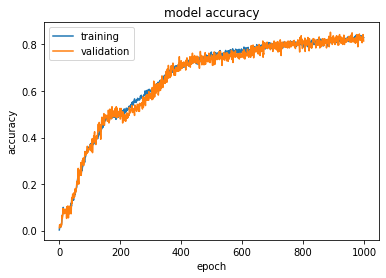

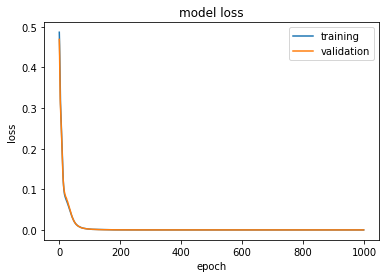

In [66]:
from tensorflow.keras.callbacks import Callback
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print('{:d}/{:.4f}/{:.4f}/{:.4f}/{:.4f} '.format(epoch, logs['loss'], logs['accuracy'], 
                logs['val_loss'], logs['val_accuracy']), end='')

test_data = x_test
test_labels = y_test

model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(units=N_POINTS))
model.add(LeakyReLU(alpha=0.03))
model.add(Dense(units=N_POINTS))

model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()

history = model.fit(xs, ys, batch_size=64, epochs=1000, verbose=0, validation_split=.2, callbacks=[MyCallback()])
plot_training_history(history, model)

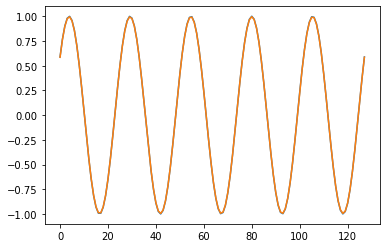

In [69]:
# looks pretty good
phase_frac = 0.1
ys = gen_example(phase_frac, 5)
plt.plot(ys)
_ = plt.plot(model.predict([phase_frac])[0])

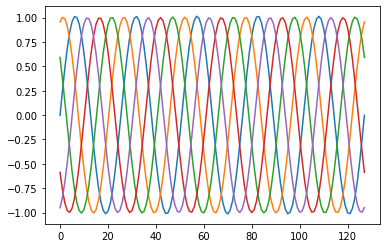

In [71]:
# clearly some issues, see the wobble at the top when all curves should reach same amplitude
for phase_frac in np.arange(0.0, 1.0, 0.2):
   _ = plt.plot(model.predict([phase_frac])[0])    

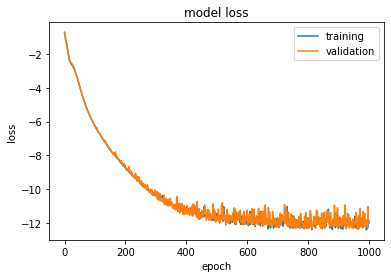

In [79]:
# get a closer look at loss
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim(0, 0.0001)
_ = plt.legend(['training', 'validation'], loc='best')